<a href="https://colab.research.google.com/github/helenatong/oc_p4_Anticipez_les_besoins_en_consommation_de_batiments/blob/main/training_target_GHG_emissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

---

## **Prérequis**
- Télécharger [dataset nettoyé](https://drive.google.com/file/d/1-EuzI1ibLAG_1brg_v3MKcDtEgKDFIdl/view?usp=drive_link) dans Google Drive
- Modifier le chemin du fichier dans le code


---

## **Prédiction de la première variable cible: Emission de carbone (TotalGHGEmissions)**

---


## **Sommaire:**

### **I. Installation et mise en place de l'environnement de travail**

### **II. Feature engineering**

### **III. Définitions des variables globales**

### **IV. Prédiction de la variable TotalGHGEmissions**

- **A. RandomForestRegressor**

- **B. GradientBoostingRegressor**

- **C. SVR**

- **D. ElasticNet**

- **E. LinearRegression**

- **F. Choix de l'algorithme**

### **V. Estimer l'effet de la variable ENERGYSTARScore**


# **I. Installation et mise en place de l'environnement de travail**

In [ ]:
# installation des librairies
!pip install shap

In [ ]:
# importation des librairies
import numpy as np
import pandas as pd

import zipfile
import os

import re

import sys

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import shap

import datetime

from google.colab import drive

In [ ]:
# informations sur l'environnement virtuel
print('Version des librairies :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + mpl.__version__)

now  = datetime.datetime.now().isoformat()
print('Run date      : ' + now)

Version des librairies :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy         : 1.25.2
Pandas        : 2.0.3
Matplotlib    : 3.7.1
Run date      : 2024-06-07T15:12:20.626608


In [ ]:
# configurations de l'affichages des données
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
# connexion au drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# vérification de l'importation
df = pd.read_parquet('/content/drive/MyDrive/openclassrooms/project_list/project_4/data/cleaned_2016_Building_Energy_Benchmarking.pq')
print (df.shape)
df.head(2)

(1474, 15)


,OSEBuildingID,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,NbBuildingUsages,BuildingAge,NbYearENERGYSTARCertified,RatioSteamUse,RatioElectricity
0,1,DOWNTOWN,1.0,12,88434,0,Hotel,60.0,7226362.5,249.98,1,89,0,0.28,0.55
1,2,DOWNTOWN,1.0,11,103566,15064,Hotel,61.0,8387933.0,295.86,3,20,0,0.00,0.39


In [ ]:
# vérification des données
df.isna().sum(axis=0)

OSEBuildingID                0
Neighborhood                 0
NumberofBuildings            0
NumberofFloors               0
PropertyGFATotal             0
PropertyGFAParking           0
LargestPropertyUseType       0
ENERGYSTARScore              0
SiteEnergyUse(kBtu)          0
TotalGHGEmissions            0
NbBuildingUsages             0
BuildingAge                  0
NbYearENERGYSTARCertified    0
RatioSteamUse                0
RatioElectricity             0
dtype: int64

# **II. Feature engineering**

**Suppression des modalités représentant moins de 5% du dataset**

In [ ]:
# Obtenir le nombre d'occurrences de chaque modalité: Neighborhood
modalities_counts = df['Neighborhood'].value_counts()
print("Nombre d'occurrences de chaque modalité :")
print(modalities_counts)
print(modalities_counts/df.shape[0])

Nombre d'occurrences de chaque modalité :
Neighborhood
DOWNTOWN                 338
GREATER DUWAMISH         319
LAKE UNION               139
MAGNOLIA / QUEEN ANNE    136
EAST                     110
NORTHEAST                 99
NORTHWEST                 74
BALLARD                   62
NORTH                     57
CENTRAL                   41
DELRIDGE                  38
SOUTHWEST                 31
SOUTHEAST                 30
Name: count, dtype: int64
Neighborhood
DOWNTOWN                 0.229308
GREATER DUWAMISH         0.216418
LAKE UNION               0.094301
MAGNOLIA / QUEEN ANNE    0.092266
EAST                     0.074627
NORTHEAST                0.067164
NORTHWEST                0.050204
BALLARD                  0.042062
NORTH                    0.038670
CENTRAL                  0.027815
DELRIDGE                 0.025780
SOUTHWEST                0.021031
SOUTHEAST                0.020353
Name: count, dtype: float64


In [ ]:
# Seuil de 5%
threshold = 0.05 * df.shape[0]

# Transformer en 'OTHER' pour les valeurs représentant moins de 5%
df['Neighborhood'] = df['Neighborhood'].apply(lambda x: x if modalities_counts[x] > threshold else 'OTHER')

In [ ]:
# Obtenir le nombre d'occurrences de chaque modalité: LargestPropertyUseType
modalities_counts = df['LargestPropertyUseType'].value_counts()
print("Nombre d'occurrences de chaque modalité :")
print(modalities_counts)
print(modalities_counts/df.shape[0])

Nombre d'occurrences de chaque modalité :
LargestPropertyUseType
Office                                                  483
Non-Refrigerated Warehouse                              197
Retail Store                                             91
Other                                                    88
Hotel                                                    76
Worship Facility                                         69
Distribution Center                                      54
Medical Office                                           41
Supermarket/Grocery Store                                40
K-12 School                                              38
Other - Recreation                                       31
Parking                                                  29
Self-Storage Facility                                    28
Other - Entertainment/Public Assembly                    21
Senior Care Community                                    20
College/University                 

In [ ]:
# Transformer en 'Other' pour les valeurs représentant moins de 5%
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].apply(lambda x: x if modalities_counts[x] > threshold else 'Other')

**Suppression des variables peu pertinentes pour notre modèle**

In [ ]:
#pas nécessaire pour l'entrainement des modèles
df.drop(columns=['OSEBuildingID'], inplace=True)

#reponsable de data leaking
df.drop(columns=['SiteEnergyUse(kBtu)'], inplace=True)

# **III. Définitions des variables globales**

In [ ]:
TARGET = 'TotalGHGEmissions'
NUM_FEATURES = ['NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'ENERGYSTARScore', 'NbBuildingUsages',
       'BuildingAge', 'NbYearENERGYSTARCertified', 'RatioSteamUse',
       'RatioElectricity', 'PropertyGFAParking']

CAT_FEATURES = [f for f in df.columns if f not in NUM_FEATURES and f != TARGET and f != 'SiteEnergyUse(kBtu)']
print(CAT_FEATURES)

['Neighborhood', 'LargestPropertyUseType']


In [ ]:
df1 = df.copy()

# **IV. Entrainement des modèles**

##**A. RandomForestRegressor**

In [ ]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
  ])

In [ ]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)
# limitation de la complexité pour éviter l'overfitting

param_grid = {
    'regressor__max_depth'         : [3, 4, 5],
    'regressor__max_features'      : [1, 3, 5],
    'regressor__min_samples_leaf'  : [1, 3],
    'regressor__criterion'         : ['squared_error', 'absolute_error'],
    'regressor__min_samples_split' : [2, 5]
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_RFR = gs.best_estimator_
score_RFR =  gs.best_score_.round(3)

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {score_RFR}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_RFR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_RFR.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_RFR.score(X_test, y_test)-best_model_RFR.score(X_train, y_train)).round(3)}')

print('----------------')
y_train_pred = best_model_RFR.predict(X_train)
MAE_RFR = mean_absolute_error(np.exp(y_train) - 1, np.exp(y_train_pred) - 1).round(3) #prendre les vraies valeurs
print(f'mean_absolute_error on train: {MAE_RFR}')
MAPE_RFR = mean_absolute_percentage_error(np.exp(y_train) - 1, np.exp(y_train_pred) - 1).round(3)
print(f'mean_absolute_percentage_error on train: {MAPE_RFR}')

mean_time_RFR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Meilleurs hyperparamètres: {'regressor__criterion': 'squared_error', 'regressor__max_depth': 5, 'regressor__max_features': 5, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Moyenne des scores: 0.65
----------------
Score sur le train : 0.695
Score sur le test : 0.619
diff = -0.076
----------------
mean_absolute_error on train: 105.837
mean_absolute_percentage_error on train: 0.912


In [ ]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__criterion,param_regressor__max_depth,param_regressor__max_features,param_regressor__min_samples_leaf,param_regressor__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.590643,0.045517,0.035962,0.004692,squared_error,3,1,1,2,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 3, 'regressor__max_features': 1, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}",0.231811,0.232252,0.314595,0.263775,0.276519,0.263790,0.030856,66
1,0.644145,0.111803,0.040378,0.012504,squared_error,3,1,1,5,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 3, 'regressor__max_features': 1, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}",0.254678,0.256706,0.274463,0.251247,0.285323,0.264483,0.013158,65
2,0.516812,0.107948,0.033418,0.003094,squared_error,3,1,3,2,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 3, 'regressor__max_features': 1, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 2}",0.275395,0.252921,0.257501,0.261341,0.262842,0.262000,0.007526,68
3,0.547983,0.104827,0.035335,0.023634,squared_error,3,1,3,5,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 3, 'regressor__max_features': 1, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 5}",0.260985,0.252462,0.261169,0.247319,0.294680,0.263323,0.016538,67
4,0.553002,0.069052,0.034717,0.012512,squared_error,3,3,1,2,"{'regressor__criterion': 'squared_error', 'regressor__max_depth': 3, 'regressor__max_features': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}",0.455398,0.413775,0.479921,0.405420,0.449203,0.440743,0.027555,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1.923678,0.234996,0.025932,0.007999,absolute_error,5,3,3,5,"{'regressor__criterion': 'absolute_error', 'regressor__max_depth': 5, 'regressor__max_features': 3, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 5}",0.541204,0.526047,0.590647,0.513876,0.568970,0.548149,0.028111,24
68,4.143232,0.813668,0.041295,0.017603,absolute_error,5,5,1,2,"{'regressor__criterion': 'absolute_error', 'regressor__max_depth': 5, 'regressor__max_features': 5, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}",0.635679,0.633604,0.666081,0.588975,0.665339,0.637935,0.028157,5
69,2.718560,0.367533,0.028634,0.016142,absolute_error,5,5,1,5,"{'regressor__criterion': 'absolute_error', 'regressor__max_depth': 5, 'regressor__max_features': 5, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}",0.619900,0.628256,0.665088,0.584702,0.664077,0.632405,0.030068,8
70,2.026418,0.453336,0.026815,0.008887,absolute_error,5,5,3,2,"{'regressor__criterion': 'absolute_error', 'regressor__max_depth': 5, 'regressor__max_features': 5, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 2}",0.627564,0.617737,0.667897,0.599473,0.654633,0.633461,0.024784,7


##**B. GradientBoostingRegressor**

In [ ]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
  ])

In [ ]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)
# limitation des paramètres pour éviter l'overfitting

param_grid = {
    'regressor__learning_rate'      : [0.10, 0.001, 0.05, 0.20],
    'regressor__max_depth'          : [1],
    'regressor__n_estimators'       : [100, 50],
    'regressor__subsample'          : [0.8, 0.9],
    'regressor__max_features'       : ['sqrt', 'log2'],
    'regressor__loss'               : ['squared_error', 'absolute_error']
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_GBR = gs.best_estimator_
score_GBR = gs.best_score_.round(3)

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {score_GBR}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_GBR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_GBR.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_GBR.score(X_test, y_test)-best_model_GBR.score(X_train, y_train)).round(3)}')

print('----------------')
y_train_pred = best_model_GBR.predict(X_train)
MAE_GBR = mean_absolute_error(np.exp(y_train) - 1, np.exp(y_train_pred) - 1).round(3)
print(f'mean_absolute_error on train: {MAE_GBR}')
MAPE_GBR = mean_absolute_percentage_error(np.exp(y_train) - 1, np.exp(y_train_pred) - 1).round(3)
print(f'mean_absolute_percentage_error on train: {MAPE_GBR}')

mean_time_GBR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Meilleurs hyperparamètres: {'regressor__learning_rate': 0.2, 'regressor__loss': 'squared_error', 'regressor__max_depth': 1, 'regressor__max_features': 'log2', 'regressor__n_estimators': 100, 'regressor__subsample': 0.9}
Moyenne des scores: 0.721
----------------
Score sur le train : 0.723
Score sur le test : 0.678
diff = -0.046
----------------
mean_absolute_error on train: 94.679
mean_absolute_percentage_error on train: 0.844


In [ ]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__learning_rate,param_regressor__loss,param_regressor__max_depth,param_regressor__max_features,param_regressor__n_estimators,param_regressor__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.160433,0.004856,0.009899,0.000468,0.1,squared_error,1,sqrt,100,0.8,"{'regressor__learning_rate': 0.1, 'regressor__loss': 'squared_error', 'regressor__max_depth': 1, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}",0.633041,0.671105,0.704118,0.604702,0.634331,0.649460,0.034519,17
1,0.164711,0.014377,0.010571,0.001921,0.1,squared_error,1,sqrt,100,0.9,"{'regressor__learning_rate': 0.1, 'regressor__loss': 'squared_error', 'regressor__max_depth': 1, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 100, 'regressor__subsample': 0.9}",0.653246,0.680633,0.698744,0.627447,0.684297,0.668873,0.025412,11
2,0.110940,0.006988,0.009643,0.000223,0.1,squared_error,1,sqrt,50,0.8,"{'regressor__learning_rate': 0.1, 'regressor__loss': 'squared_error', 'regressor__max_depth': 1, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 50, 'regressor__subsample': 0.8}",0.572634,0.531656,0.588109,0.544809,0.572414,0.561924,0.020589,27
3,0.112627,0.007643,0.009692,0.000205,0.1,squared_error,1,sqrt,50,0.9,"{'regressor__learning_rate': 0.1, 'regressor__loss': 'squared_error', 'regressor__max_depth': 1, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 50, 'regressor__subsample': 0.9}",0.581236,0.577672,0.585727,0.521976,0.612754,0.575873,0.029645,24
4,0.177509,0.013078,0.013277,0.004536,0.1,squared_error,1,log2,100,0.8,"{'regressor__learning_rate': 0.1, 'regressor__loss': 'squared_error', 'regressor__max_depth': 1, 'regressor__max_features': 'log2', 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}",0.638004,0.673740,0.719120,0.608417,0.682703,0.664397,0.038072,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.158500,0.003102,0.011027,0.002373,0.2,absolute_error,1,sqrt,50,0.9,"{'regressor__learning_rate': 0.2, 'regressor__loss': 'absolute_error', 'regressor__max_depth': 1, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 50, 'regressor__subsample': 0.9}",0.644408,0.633400,0.680350,0.618765,0.688752,0.653135,0.027041,16
60,0.257363,0.010290,0.011168,0.001513,0.2,absolute_error,1,log2,100,0.8,"{'regressor__learning_rate': 0.2, 'regressor__loss': 'absolute_error', 'regressor__max_depth': 1, 'regressor__max_features': 'log2', 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}",0.682160,0.722361,0.723793,0.643337,0.707909,0.695912,0.030246,5
61,0.253901,0.010862,0.009524,0.000161,0.2,absolute_error,1,log2,100,0.9,"{'regressor__learning_rate': 0.2, 'regressor__loss': 'absolute_error', 'regressor__max_depth': 1, 'regressor__max_features': 'log2', 'regressor__n_estimators': 100, 'regressor__subsample': 0.9}",0.638463,0.700879,0.731273,0.666765,0.738955,0.695267,0.038146,6
62,0.162091,0.007065,0.009480,0.000294,0.2,absolute_error,1,log2,50,0.8,"{'regressor__learning_rate': 0.2, 'regressor__loss': 'absolute_error', 'regressor__max_depth': 1, 'regressor__max_features': 'log2', 'regressor__n_estimators': 50, 'regressor__subsample': 0.8}",0.635240,0.668698,0.650097,0.581818,0.694437,0.646058,0.037718,20


##**C. SVR**

In [ ]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
  ])

In [ ]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__kernel'          : ['rbf', 'poly', 'linear', 'sigmoid'], #passer dans les dimensions supérieures
    'regressor__degree'          : [3, 2, 4], #for poly
    'regressor__gamma'           : ['scale', 'auto'], #for rbf, poly and sigmoid
    'regressor__tol'             : [1e-3]
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_SVR = gs.best_estimator_
score_SVR = gs.best_score_.round(3)

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {score_SVR}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_SVR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_SVR.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_SVR.score(X_test, y_test)-best_model_SVR.score(X_train, y_train)).round(3)}')

print('----------------')
y_train_pred = best_model_SVR.predict(X_train)
MAE_SVR = mean_absolute_error(np.exp(y_train) - 1, np.exp(y_train_pred) - 1).round(3)
print(f'mean_absolute_error on train: {MAE_SVR}')
MAPE_SVR = mean_absolute_percentage_error(np.exp(y_train) - 1, np.exp(y_train_pred) - 1).round(3)
print(f'mean_absolute_percentage_error on train: {MAPE_SVR}')

mean_time_SVR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs hyperparamètres: {'regressor__degree': 3, 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf', 'regressor__tol': 0.001}
Moyenne des scores: 0.724
----------------
Score sur le train : 0.773
Score sur le test : 0.757
diff = -0.016
----------------
mean_absolute_error on train: 94.729
mean_absolute_percentage_error on train: 0.656


In [ ]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__degree,param_regressor__gamma,param_regressor__kernel,param_regressor__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.170824,0.009614,0.034855,0.003190,3,scale,rbf,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf', 'regressor__tol': 0.001}",0.651451,0.727634,0.730969,0.675671,0.731803,0.703506,0.033531,11
1,0.179628,0.009277,0.021030,0.002132,3,scale,poly,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'scale', 'regressor__kernel': 'poly', 'regressor__tol': 0.001}",0.654377,0.700936,0.716229,0.620044,0.752926,0.688902,0.046742,14
2,0.252029,0.019689,0.019541,0.001261,3,scale,linear,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear', 'regressor__tol': 0.001}",0.656245,0.750885,0.732708,0.674888,0.761445,0.715234,0.041998,4
3,0.192608,0.008919,0.031910,0.001174,3,scale,sigmoid,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'scale', 'regressor__kernel': 'sigmoid', 'regressor__tol': 0.001}",-13.707517,-10.151521,-17.334184,-18.851987,-13.371361,-14.683314,3.085952,22
4,0.152268,0.005487,0.032993,0.000444,3,auto,rbf,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf', 'regressor__tol': 0.001}",0.672252,0.748429,0.751055,0.691372,0.756264,0.723874,0.034963,1
5,0.143841,0.006091,0.020830,0.001113,3,auto,poly,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'auto', 'regressor__kernel': 'poly', 'regressor__tol': 0.001}",0.592100,0.592866,0.640788,0.541698,0.653962,0.604283,0.039991,17
6,0.244762,0.013926,0.019191,0.000490,3,auto,linear,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'auto', 'regressor__kernel': 'linear', 'regressor__tol': 0.001}",0.656245,0.750885,0.732708,0.674888,0.761445,0.715234,0.041998,4
7,0.190514,0.015191,0.030211,0.001832,3,auto,sigmoid,0.001,"{'regressor__degree': 3, 'regressor__gamma': 'auto', 'regressor__kernel': 'sigmoid', 'regressor__tol': 0.001}",0.184317,0.392718,0.025762,0.127702,0.250522,0.196204,0.122843,19
8,0.155906,0.002835,0.033781,0.001847,2,scale,rbf,0.001,"{'regressor__degree': 2, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf', 'regressor__tol': 0.001}",0.651451,0.727634,0.730969,0.675671,0.731803,0.703506,0.033531,11
9,0.168041,0.011572,0.020665,0.001027,2,scale,poly,0.001,"{'regressor__degree': 2, 'regressor__gamma': 'scale', 'regressor__kernel': 'poly', 'regressor__tol': 0.001}",0.674591,0.712595,0.751418,0.668163,0.765460,0.714445,0.039251,10


##**D. ElasticNet**

In [ ]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
  ])

In [ ]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__alpha'          : [1, 0.05, 0.1, 0.5, 1.5],
    'regressor__l1_ratio'       : [0.5, 0.10, 0.20, 0.75],
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_EN = gs.best_estimator_
score_EN = gs.best_score_.round(3)

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {score_EN}')
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_EN.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_EN.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_EN.score(X_test, y_test)-best_model_EN.score(X_train, y_train)).round(3)}')

print('----------------')
y_train_pred = best_model_EN.predict(X_train)
MAE_EN = mean_absolute_error(np.exp(y_train) - 1, np.exp(y_train_pred) - 1).round(3)
print(f'mean_absolute_error on train: {MAE_EN}')
MAPE_EN = mean_absolute_percentage_error(np.exp(y_train) - 1, np.exp(y_train_pred) - 1).round(3)
print(f'mean_absolute_percentage_error on train: {MAPE_EN}')

mean_time_EN = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs hyperparamètres: {'regressor__alpha': 0.05, 'regressor__l1_ratio': 0.1}
Moyenne des scores: 0.714
----------------
Score sur le train : 0.725
Score sur le test : 0.734
diff = 0.009
----------------
mean_absolute_error on train: 108.28
mean_absolute_percentage_error on train: 0.811


In [ ]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,param_regressor__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.062187,0.007688,0.009239,0.000269,1,0.5,"{'regressor__alpha': 1, 'regressor__l1_ratio': 0.5}",0.257562,0.239042,0.252173,0.251056,0.234096,0.246786,0.008768,17
1,0.060771,0.005049,0.009554,0.000865,1,0.1,"{'regressor__alpha': 1, 'regressor__l1_ratio': 0.1}",0.457440,0.482372,0.499783,0.446675,0.494795,0.476213,0.020802,12
2,0.059735,0.003836,0.009578,0.001359,1,0.2,"{'regressor__alpha': 1, 'regressor__l1_ratio': 0.2}",0.422883,0.426324,0.439788,0.402120,0.431523,0.424528,0.012569,14
3,0.058684,0.004228,0.008861,0.000194,1,0.75,"{'regressor__alpha': 1, 'regressor__l1_ratio': 0.75}",0.062590,0.043407,0.041676,0.058100,0.034221,0.047999,0.010638,18
4,0.062425,0.007891,0.010017,0.001504,0.05,0.5,"{'regressor__alpha': 0.05, 'regressor__l1_ratio': 0.5}",0.650800,0.738470,0.738904,0.665144,0.748859,0.708435,0.041618,3
5,0.065247,0.009223,0.008822,0.000080,0.05,0.1,"{'regressor__alpha': 0.05, 'regressor__l1_ratio': 0.1}",0.658478,0.744288,0.743483,0.669562,0.752292,0.713621,0.040767,1
6,0.058220,0.003930,0.008937,0.000170,0.05,0.2,"{'regressor__alpha': 0.05, 'regressor__l1_ratio': 0.2}",0.655068,0.742000,0.742439,0.667855,0.750758,0.711624,0.041275,2
7,0.061137,0.004940,0.010810,0.003887,0.05,0.75,"{'regressor__alpha': 0.05, 'regressor__l1_ratio': 0.75}",0.648825,0.734386,0.734046,0.663411,0.746880,0.705509,0.040853,4
8,0.064364,0.012021,0.008787,0.000169,0.1,0.5,"{'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.5}",0.639755,0.714001,0.719944,0.649464,0.733503,0.691333,0.038792,7
9,0.061287,0.005230,0.008996,0.000246,0.1,0.1,"{'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.1}",0.649878,0.730407,0.736582,0.660028,0.742358,0.703851,0.040231,5


##**E. LinearRegression**

In [ ]:
# séparation des variables explicatives de la variable à prédire
df1 = df.copy()
y = df1.pop(TARGET)
X = df1

In [ ]:
# features engineering
y = np.log(y + 1)

preprocessor = ColumnTransformer(
    transformers=[
        ('encoder_nominal', OneHotEncoder(handle_unknown='ignore',sparse_output=False), CAT_FEATURES),
         ('norma', PowerTransformer(), NUM_FEATURES)
    ],
    remainder='drop'
  )

In [ ]:
# création de la pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
  ])

In [ ]:
# entrainement des modèles selon plusieurs paramètres
# séparation du dataset (entrainement et test)

param_grid = {
    'regressor__fit_intercept' : [False, True]
    }

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2') #1476*0.80/5 = 236 données par pli pour cv=5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_LR = gs.best_estimator_
score_LR = gs.best_score_.round(3)

print(f'Meilleurs hyperparamètres: {gs.best_params_}')
print(f'Moyenne des scores: {score_LR}') #moyenne des scores sur la validation croisée
print('----------------')

# model scoring
print(f'Score sur le train : {best_model_LR.score(X_train, y_train).round(3)}')
print(f'Score sur le test : {best_model_LR.score(X_test, y_test).round(3)}')
print(f'diff = {(best_model_LR.score(X_test, y_test)-best_model_LR.score(X_train, y_train)).round(3)}')

print('----------------')
y_train_pred = best_model_LR.predict(X_train)
MAE_LR = mean_absolute_error(np.exp(y_train) - 1, np.exp(y_train_pred) - 1).round(3)
print(f'mean_absolute_error on train: {MAE_LR}')
MAPE_LR = mean_absolute_percentage_error(np.exp(y_train) - 1, np.exp(y_train_pred) - 1).round(3)
print(f'mean_absolute_percentage_error on train: {MAPE_LR}')

mean_time_LR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs hyperparamètres: {'regressor__fit_intercept': False}
Moyenne des scores: 0.752
----------------
Score sur le train : 0.764
Score sur le test : 0.77
diff = 0.006
----------------
mean_absolute_error on train: 100.786
mean_absolute_percentage_error on train: 0.708


In [ ]:
# détails de la validation croisée
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.072180,0.009306,0.009263,0.000274,False,{'regressor__fit_intercept': False},0.706085,0.785116,0.775325,0.722552,0.768454,0.751507,0.031259,1
1,0.065232,0.002261,0.008691,0.001264,True,{'regressor__fit_intercept': True},0.706085,0.785116,0.774108,0.722552,0.768454,0.751263,0.031077,2


## **F. Choix de l'algorithme**

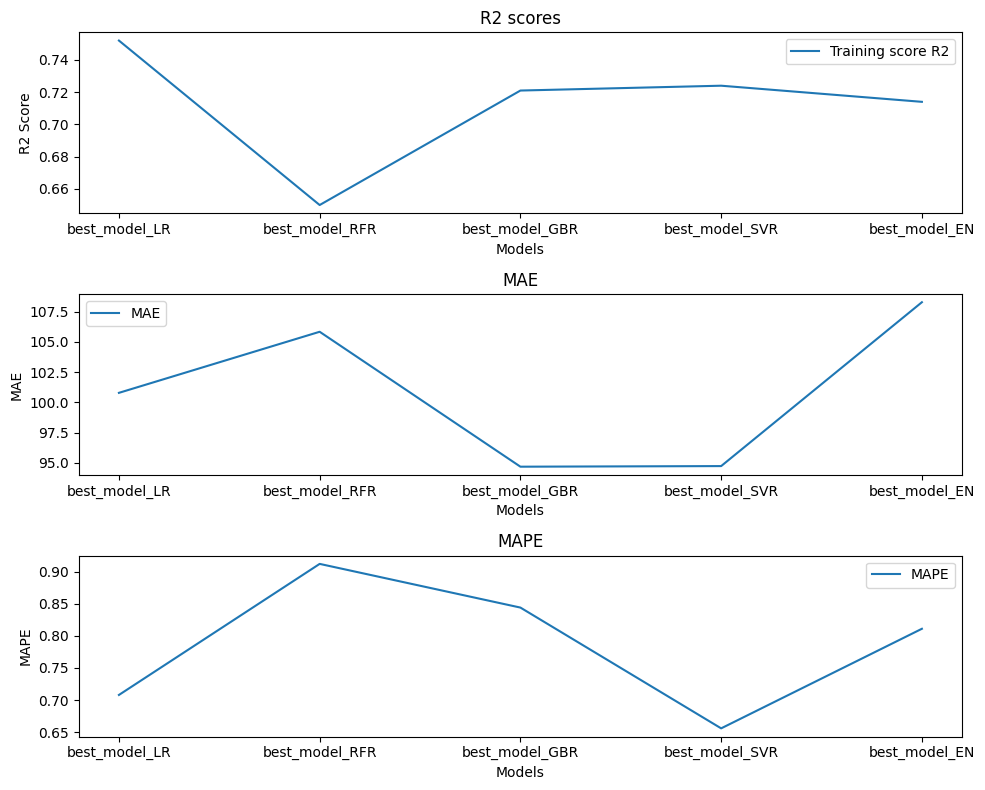

In [ ]:
# visualisation des scores R2, MAE et MAPE des différents modèles
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

models        = ['best_model_LR', 'best_model_RFR', 'best_model_GBR', 'best_model_SVR', 'best_model_EN']
best_score    = [score_LR, score_RFR, score_GBR, score_SVR, score_EN]
MAE           = [MAE_LR, MAE_RFR, MAE_GBR, MAE_SVR, MAE_EN]
MAPE          = [MAPE_LR, MAPE_RFR, MAPE_GBR, MAPE_SVR, MAPE_EN]

# Premier graphique : R2
ax[0].plot(models, best_score, label='Training score R2')
ax[0].set_title('R2 scores')
ax[0].legend()
ax[0].set_xlabel('Models')
ax[0].set_ylabel('R2 Score')

# Deuxième graphique : MAE
ax[1].plot(models, MAE, label='MAE')
ax[1].set_title('MAE')
ax[1].legend()
ax[1].set_xlabel('Models')
ax[1].set_ylabel('MAE')

# Deuxième graphique : MAPE
ax[2].plot(models, MAPE, label='MAPE')
ax[2].set_title('MAPE')
ax[2].legend()
ax[2].set_xlabel('Models')
ax[2].set_ylabel('MAPE')

plt.tight_layout()
plt.show()

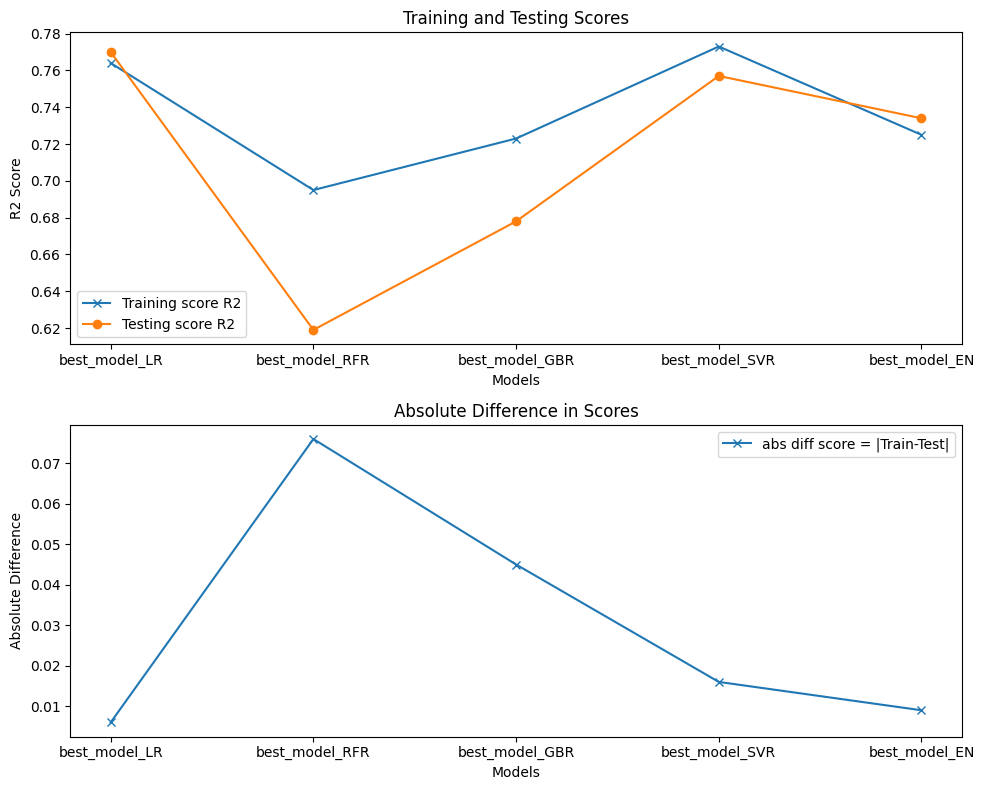

In [ ]:
# visualisation des scores d'entrainemet et de test pour vérifier la cohérence
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

train_score  = [best_model_LR.score(X_train, y_train).round(3), best_model_RFR.score(X_train, y_train).round(3), best_model_GBR.score(X_train, y_train).round(3), best_model_SVR.score(X_train, y_train).round(3), best_model_EN.score(X_train, y_train).round(3)]
test_score    = [best_model_LR.score(X_test, y_test).round(3), best_model_RFR.score(X_test, y_test).round(3), best_model_GBR.score(X_test, y_test).round(3), best_model_SVR.score(X_test, y_test).round(3), best_model_EN.score(X_test, y_test).round(3)]
diff_score = [np.abs(a - b) for a, b in zip(train_score, test_score)]

# Premier graphique : scores d'entraînement et de test
ax[0].plot(models, train_score, label='Training score R2', marker='x')
ax[0].plot(models, test_score, label='Testing score R2', marker='o')
ax[0].set_title('Training and Testing Scores')
ax[0].legend()
ax[0].set_xlabel('Models')
ax[0].set_ylabel('R2 Score')

# Deuxième graphique : différences de scores
ax[1].plot(models, diff_score, label='abs diff score = |Train-Test|', marker='x')
ax[1].set_title('Absolute Difference in Scores')
ax[1].legend()
ax[1].set_xlabel('Models')
ax[1].set_ylabel('Absolute Difference')

plt.tight_layout()
plt.show()

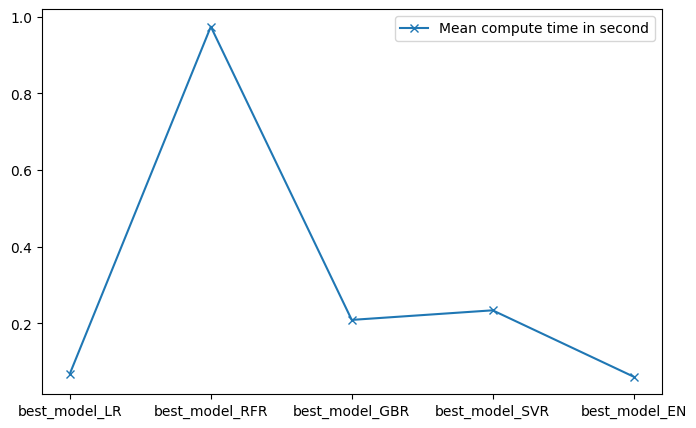

In [ ]:
# visualisation du temps de computage
plt.figure(figsize=(8,5))
mean_process_time = [mean_time_LR, mean_time_RFR, mean_time_GBR, mean_time_SVR, mean_time_EN]
plt.plot(models, mean_process_time, label='Mean compute time in second', marker='x')

plt.legend()
plt.show()

Si on s'appuie sur les scores de R2, tous les modèles sont intéressants sauf l'algorithme des forêts aléatoires.

Si on compare la régression linéaire à elastic net, on voit que la régression est meilleure pour R2, MAE et MAPE.

Le modèle de régression linéaire présente le R2 le plus élevé, semble également plus robuste (la différence entre le test et le train est la plus faible), est le plus rapide à calculer et la valeur du MAPE figure parmi les meilleurs.

Enfin, les résultats étant assez similaires, j'ai choisi de prendre le modèle le plus simple, c'est-à-dire la régression linéaire.

In [ ]:
# Récupération des hyperparamètres
print('liste des parameters de la régression lineaire :')
print(f'intercept: {best_model_LR[1].intercept_}')

print(best_model_LR[1].get_params())

liste des parameters de la régression lineaire :
intercept: 0.0
{'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'positive': False}


In [454]:
# Récupération des coefficients
feature_names = best_model_LR.named_steps['preprocessor'].get_feature_names_out()
coefficients = best_model_LR.named_steps['regressor'].coef_.round(2)
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coef_df_sorted = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)
coef_df_sorted

,Feature,Coefficient
12,encoder_nominal__LargestPropertyUseType_Retail Store,2.67
11,encoder_nominal__LargestPropertyUseType_Other,2.61
10,encoder_nominal__LargestPropertyUseType_Office,2.55
8,encoder_nominal__LargestPropertyUseType_Hotel,2.51
9,encoder_nominal__LargestPropertyUseType_Non-Refrigerated Warehouse,1.86
3,encoder_nominal__Neighborhood_LAKE UNION,1.70
5,encoder_nominal__Neighborhood_NORTHEAST,1.66
0,encoder_nominal__Neighborhood_DOWNTOWN,1.64
1,encoder_nominal__Neighborhood_EAST,1.55
7,encoder_nominal__Neighborhood_OTHER,1.48


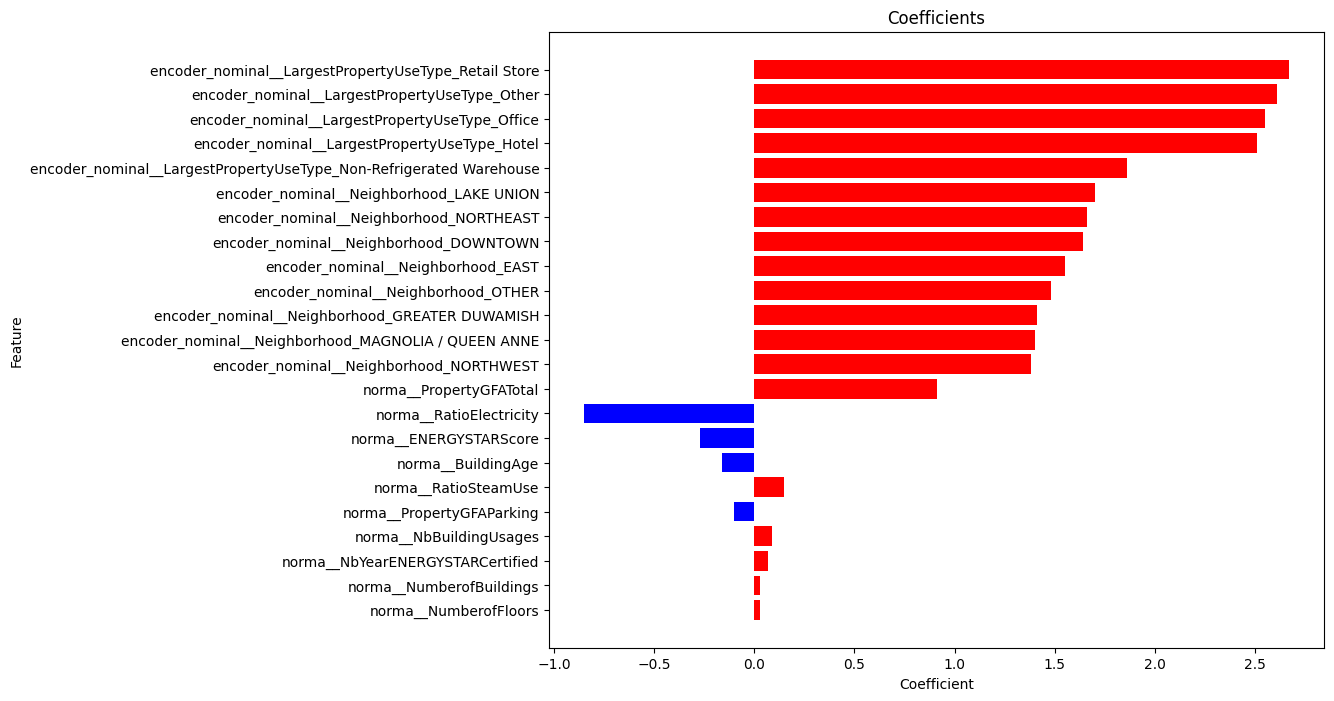

In [455]:
plt.figure(figsize=(10, 8))
colors = ['red' if coef > 0 else 'blue' for coef in coef_df_sorted['Coefficient']]
plt.barh(coef_df_sorted['Feature'], coef_df_sorted['Coefficient'], color=colors)
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title('Coefficients')
plt.gca().invert_yaxis()
plt.show()

Les variables qui ont le plus d'impact sur le modèle sont dans l'ordre: l'usage principal du bâtiment (2.64-1.92), le quartier (1.30-1.69), la surface (0.87) et le ratio de l'énergie électrique consommé (-0.84).

- Les émissions de carbones sont plus ou moins élevés selon l'usage du bâtiment. En effet, les batiments de stockages ont des besoins moindre par rapport à des bureaux (ouvert en journée), ou à des supermarchés (ouvert en journée et utilisation d'énergie pour conserver les aliments frais).
- Certains quartiers concentrent davantage certaines activités ce qui peut expliquer leur influence.
- Plus la superficie est grande, plus les besoins énergétiques sont importants, ce qui se traduit par des émissions de carbones plus élevées.
- L'électricité est souvent plus efficace que d'autres sources d'énergie fossile, ce qui peut également contribuer à des émissions de CO2 plus faibles.


# **V. Estimer l'effet de la variable ENERGYSTARScore**

In [ ]:
# préparation des données
NUM_FEATURES = ['NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'NbBuildingUsages',
       'BuildingAge', 'NbYearENERGYSTARCertified', 'RatioSteamUse',
       'RatioElectricity', 'PropertyGFAParking']

CAT_FEATURES = [f for f in df.columns if f not in NUM_FEATURES and f != TARGET and f != 'SiteEnergyUse(kBtu)' and f != 'ENERGYSTARScore']
print(CAT_FEATURES)

['Neighborhood', 'LargestPropertyUseType']


In [ ]:
df2 = df.copy()
df2.drop(columns=['ENERGYSTARScore'], inplace=True)

y = df2.pop(TARGET)
X = df2
y = np.log(y + 1)

In [ ]:
# entrainement du modèle avec les mêmes hyperparamètres
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder_nominal', OneHotEncoder(handle_unknown='ignore',sparse_output=False), CAT_FEATURES),
         ('norma', PowerTransformer(), NUM_FEATURES)
    ],
    remainder='drop'
  )

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
  ])

param_grid = {
    'regressor__fit_intercept' : [False]
    }

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit=True, scoring='r2') #1476*0.80/5 = 236 données par pli pour cv=5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
gs.fit(X_train, y_train)
best_model_LR_minus_star = gs.best_estimator_
score_LR_minus_star = gs.best_score_.round(3)

print(f'Moyenne des scores: {score_LR_minus_star}') #moyenne des scores sur la validation croisée
print('----------------')

# model scoring
best_score_LR_train_minus_star = best_model_LR_minus_star.score(X_train, y_train).round(3)
best_score_LR_test_minus_star  = best_model_LR_minus_star.score(X_test, y_test).round(3)
print(f'Score sur le train : {best_score_LR_train_minus_star}')
print(f'Score sur le test : {best_score_LR_test_minus_star}')
print(f'diff = {(best_score_LR_train_minus_star-best_score_LR_test_minus_star).round(3)}')

print('----------------')
y_train_pred = best_model_LR_minus_star.predict(X_train)
MAE_LR_minus_star = mean_absolute_error(np.exp(y_train) - 1, np.exp(y_train_pred) - 1).round(3)
print(f'mean_absolute_error on train: {MAE_LR_minus_star}')
MAPE_LR_minus_star = mean_absolute_percentage_error(np.exp(y_train) - 1, np.exp(y_train_pred) - 1).round(3)
print(f'mean_absolute_percentage_error on train: {MAPE_LR_minus_star}')

mean_time_LR = gs.cv_results_['mean_fit_time'].mean().round(3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Moyenne des scores: 0.718
----------------
Score sur le train : 0.732
Score sur le test : 0.73
diff = 0.002
----------------
mean_absolute_error on train: 105.663
mean_absolute_percentage_error on train: 0.79


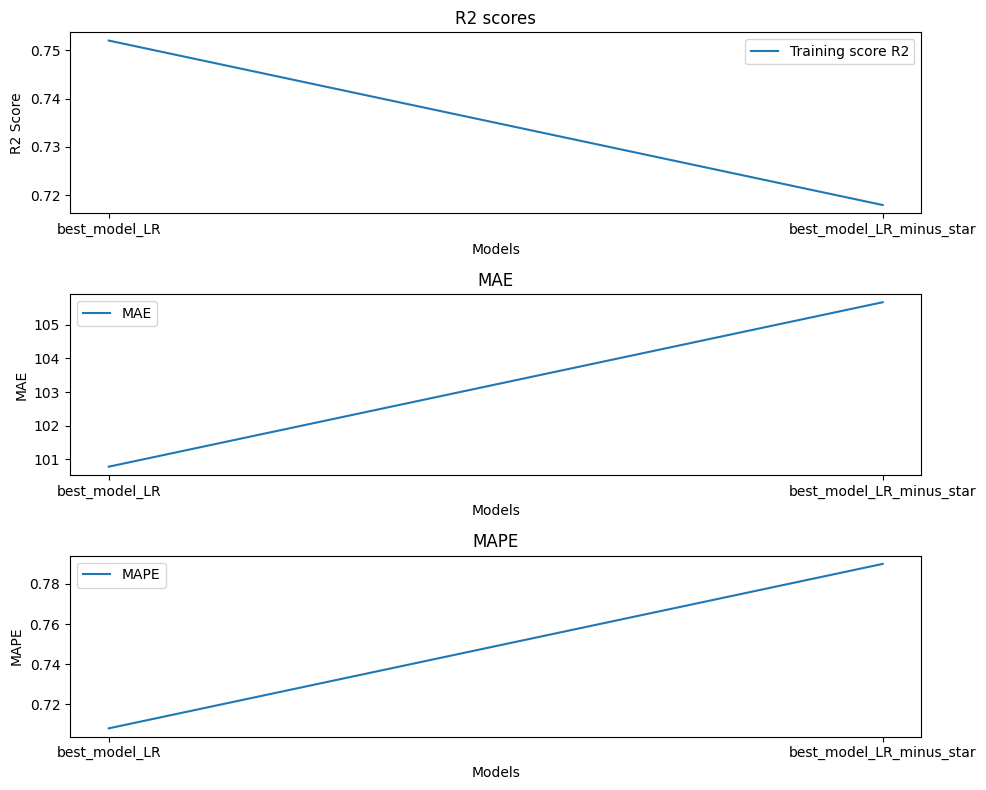

In [ ]:
# visualisation des scores R2, MAE et MAPE des différents modèles
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

models        = ['best_model_LR', 'best_model_LR_minus_star']
best_score    = [score_LR, score_LR_minus_star]
MAE           = [MAE_LR, MAE_LR_minus_star]
MAPE          = [MAPE_LR, MAPE_LR_minus_star]

# Premier graphique : scores des modèle
ax[0].plot(models, best_score, label='Training score R2')
ax[0].set_title('R2 scores')
ax[0].legend()
ax[0].set_xlabel('Models')
ax[0].set_ylabel('R2 Score')

# Deuxième graphique : MAE
ax[1].plot(models, MAE, label='MAE')
ax[1].set_title('MAE')
ax[1].legend()
ax[1].set_xlabel('Models')
ax[1].set_ylabel('MAE')

# Deuxième graphique : MAPE
ax[2].plot(models, MAPE, label='MAPE')
ax[2].set_title('MAPE')
ax[2].legend()
ax[2].set_xlabel('Models')
ax[2].set_ylabel('MAPE')

plt.tight_layout()
plt.show()

In [ ]:
print(f'diff R2: {(score_LR-score_LR_minus_star).round(2)}')
print(f'diff MAE: {(MAE_LR-MAE_LR_minus_star).round(2)}')
print(f'diff MAPE: {(MAPE_LR-MAPE_LR_minus_star).round(2)}')

print(f'moyenne émission de carbones: {(df[TARGET].mean()).round(2)}')
print(f'médiane émission de carbones: {(df[TARGET].median()).round(2)}')

diff R2: 0.03
diff MAE: -4.88
diff MAPE: -0.08
moyenne émission de carbones: 169.52
médiane émission de carbones: 49.04


#**Conclusion**

Sans la variable ENERGYSTARScore, la perte de précision est de l'ordre de 0.03 ce qui peut s'expliquer par l'ffet mécanique induit par le retrait d'une variable, l'augmentation de MAE est de 5 tonnes d'émission de carbones et celle de MAPE de +8%.

5 tonnes d'émissions de CO2 reste acceptable pour les bâtiments émetteurs de grandes quantités de CO2. Mais si on regarde la valeur médiane, 5 tonnes correspond à une erreur de 10%.

Puisque la variable ENERGYSTARScore est très coûteuse à calculer, que la perte de précision est acceptable et que la variable à prédire ne nécessite pas une précision très fine, je le retirerai.

---
Le modèle choisi est le modèle de régression linéaire dont la valeur de R² est de 0.75.